![](../header.jpg)

# KITTI 2011 09 28 Raw Data

## Data Sets

Data from [KITTI](http://www.cvlibs.net/datasets/kitti/setup.php). If you go to the [Raw Data page](http://www.cvlibs.net/datasets/kitti/raw_data.php) and download the following data sets (direct links are below, they want to harvest your email address to get the data, **sorry**): 

- [grayscale (400MB)](https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0001/2011_09_26_drive_0001_sync.zip)
- [calibration (300MB)](https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip)

Note, the video is **big** and why I don't provide a copy of it.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2          # opencv itself
import numpy as np  # matrix manipulations

import platform
import os

from ipywidgets import Video
from tqdm import tqdm
from matplotlib import pyplot as plt

from helper import imshow
from helper import videoWriter
from helper import plotSensors, printCameraParams
from helper import gray2rgb

# this is slightly modified
import wernstrom as pykitti

## Sensor Layout

<img src="setup.png" width="85%">

## Video

As shown in the diagram above, there are two sets of cameras: Point Grey Flea 2 (FL-14S3M-C) 1.4 Megapixel grayscale (0 and 1) and Point Grey Flea 2 (FL-14S3C-C) 1.4 Megapixel color (2, 3) cameras. I am just working with the grayscale, rectified, uncompressed (lossless png is what they say).

In [3]:
# for i in range(21):
#     seq = f"{i:02d}"
#     vidname = f"cam2-{seq}.mp4"
#     if not os.path.exists(vidname):
#         dataset = pykitti.odometry('../dataset/training', seq)
#         videoWriter(dataset.cam2, vidname, fps=10)

seq = "00"
dataset = pykitti.raw('../dataset/training', seq)

Found 154 samples of data at 10Hz


In [4]:
Video.from_file(f"cam2-{seq}.mp4",autoplay=False)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00C\xc0Mmdat\x00\x00\…

## Data Time Stamps

The time stamps come in a couple of different flavors, you will have to look at the data to figure out how to decode it.

In [5]:
stamps = dataset.timestamps
print(stamps[:5]) 

[0.  0.1 0.2 0.3 0.4]


## Inertial Measurement Unit

The car was equiped with the following:

| Models | Position (m) | Velocity (km/h) | Pitch / Roll (deg) | Heading (deg) | Slip angle at 50 km/h (deg) | Dual antenna |
|---|---|---|---|---|---|---|
| RT3003 | 1.5/SPS, 0.6/SBAS, 0.4/DGPS, 0.01/RTK | 0.05 | 0.03 | 0.1 | 0.15 | Yes |

- [link](https://www.oxts.com/products/rt3000/)
- [datasheet](rt3000.pdf)

In [7]:
# let's look at the first data sample, they use namedtuples,
# so the parameters are named so you know what they are. Now,
# there are some flags at the end that I don't know what they
# are ... they do a poor job of describing the setup in ONE place.
# I am sure if I scoured the internet, I could find the info.
print('Raw Data Packet:\n')
print(dataset.oxts[0].packet)
print('-'*50)
print('Homogeneous Transform starting from the origin:\n')
print(dataset.oxts[0].T_w_imu)

Raw Data Packet:

OxtsPacket(lat=49.011212804408, lon=8.4228850417969, alt=112.83492279053, roll=0.022447, pitch=1e-05, yaw=-1.2219096732051, vn=-3.3256321640686, ve=1.1384311814592, vf=3.5147680214713, vl=0.037625160413037, vu=-0.03878884255623, ax=-0.29437452763793, ay=0.037166856911681, az=9.9957015129717, af=-0.30581030960531, al=-0.19635662515203, au=9.9942128010936, wx=-0.017332142869546, wy=0.024792163815438, wz=0.14511808479348, wf=-0.017498934149631, wl=0.021393359392165, wu=0.14563031426063, pos_accuracy=0.49229361157748, vel_accuracy=0.068883960397178, navstat=4, numsats=10, posmode=4, velmode=4, orimode=0)
--------------------------------------------------
Homogeneous Transform starting from the origin:

[[ 3.41851748e-01  9.39517225e-01 -2.10894666e-02  0.00000000e+00]
 [-9.39753895e-01  3.41765417e-01 -7.68229696e-03  0.00000000e+00]
 [-1.00000000e-05  2.24451150e-02  9.99748077e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


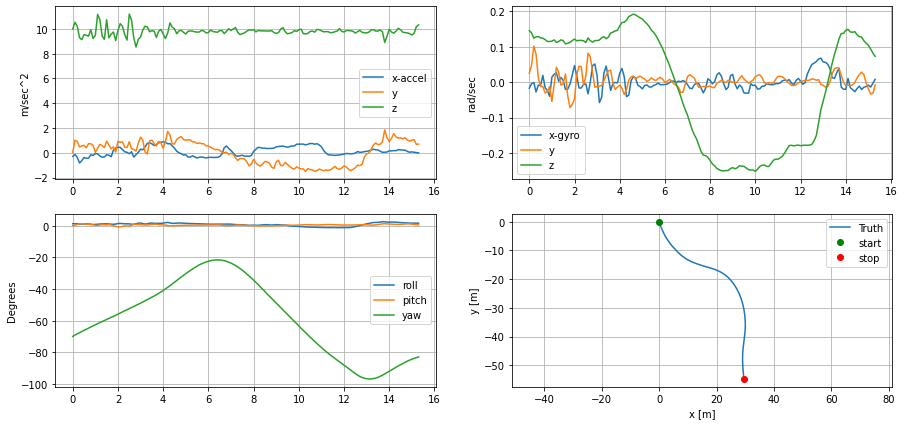

In [12]:
# plot the IMU and GPS position
plotSensors(dataset.imu, dataset.oxts, dataset.timestamps, degrees=True)

## Transforms

In [57]:
# calculate camera positions relative to camera0
P_rect_00 = dataset.calib.P_rect_00
P_rect_10 = dataset.calib.P_rect_10
P_rect_20 = dataset.calib.P_rect_20
P_rect_30 = dataset.calib.P_rect_30

T00 = np.eye(4)
T00[0, 3] = P_rect_00[0, 3] / P_rect_00[0, 0]
T10 = np.eye(4)
T10[0, 3] = P_rect_10[0, 3] / P_rect_10[0, 0]
T20 = np.eye(4)
T20[0, 3] = P_rect_20[0, 3] / P_rect_20[0, 0]
T30 = np.eye(4)
T30[0, 3] = P_rect_30[0, 3] / P_rect_30[0, 0]

print(T00)
print(T10)
print(T20)
print(T30)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[ 1.          0.          0.         -0.53716572]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]
[[1.         0.         0.         0.06313121]
 [0.         1.         0.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]]
[[ 1.          0.          0.         -0.46920065]
 [ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [13]:
dataset.calib.K_cam0

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

In [17]:
dataset.calib.P_rect_10

array([[ 721.5377,    0.    ,  609.5593, -387.5744],
       [   0.    ,  721.5377,  172.854 ,    0.    ],
       [   0.    ,    0.    ,    1.    ,    0.    ]])

In [18]:
# originally, the translation (3rd column) is in pixels
dataset.calib.P_rect_10[:,3]

array([-387.5744,    0.    ,    0.    ])

In [20]:
# now the translation is in meters, since we divied
# by the focal length. If you look at the diagram at
# the top, you will see 0.54 m between cameras.
dataset.calib.P_rect_10[:,3] / dataset.calib.P_rect_10[0,0]

array([-0.53715059,  0.        ,  0.        ])